In [1]:
pip install yellowbrick

In [2]:
pip install imblearn

In [3]:
import pandas as pd  # Library untuk manipulasi data dalam bentuk DataFrame
import numpy as np  # Library untuk komputasi numerik, operasi array, dan matriks
import matplotlib.pyplot as plt  # Library untuk membuat visualisasi grafik
import seaborn as sns  # Library untuk visualisasi data statistik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV  # Fungsi untuk membagi data dan mencari hyperparameter terbaik
from sklearn.svm import SVC  # Support Vector Classifier, digunakan untuk klasifikasi
from yellowbrick.classifier import ROCAUC  # Visualisasi ROC curve dari library Yellowbrick
from imblearn.over_sampling import SMOTE  # Teknik untuk menangani data yang tidak seimbang dengan oversampling kelas minoritas
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score  # Evaluasi model seperti ROC curve, AUC, precision, recall, dan akurasi
from sklearn.metrics import confusion_matrix
import joblib
from google.colab import drive
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [4]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset Skripsi/data_preprocessed.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,moid
0,-1.404852,1.458702,1.572803,0.816947,0.813685,0,0.105261
1,-1.628087,2.083379,2.152058,2.280802,0.701647,1,0.030238
2,-0.599112,0.075635,0.147109,-0.979324,1.247151,0,0.059966
3,-0.885132,0.436994,0.542769,1.090705,-0.513372,0,0.154436
4,-0.163105,-0.288098,-0.272000,0.215038,1.051623,0,0.034305


In [6]:
# Memisahkan kolom fitur dan target
X = df.drop(columns=['is_hazardous']) # Fitur
y = df['is_hazardous'] # Target

In [7]:
# Menangani data yang tidak seimbang pada kolom target (is hazardous)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Original y distribution: {y.value_counts()}')
print(f'Resampled y distribution: {pd.Series(y_resampled).value_counts()}')

Original y distribution: is_hazardous
0    267017
1     35632
Name: count, dtype: int64
Resampled y distribution: is_hazardous
0    267017
1    267017
Name: count, dtype: int64


In [8]:
# Membagi data menjadi data training dan data test dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Melihat jumlah data pada training set dan test set
print(f'Jumlah data pada training set (X_train): {len(X_train)}')
print(f'Jumlah data pada test set (X_test): {len(X_test)}')
print(f'Jumlah label pada training set (y_train): {len(y_train)}')
print(f'Jumlah label pada test set (y_test): {len(y_test)}')

Jumlah data pada training set (X_train): 427227
Jumlah data pada test set (X_test): 106807
Jumlah label pada training set (y_train): 427227
Jumlah label pada test set (y_test): 106807


In [9]:
# Definisikan model SVC
svc = SVC(probability=True, random_state=42)

# Definisikan parameter grid untuk pencarian
param_grid_svc = {
    'C': [1, 10],
    'kernel': ['linear']
}

# Halving Grid Search
grid_svc = HalvingGridSearchCV(estimator=svc, param_grid=param_grid_svc,
                               factor=2, cv=2, n_jobs=-1, verbose=2, scoring='roc_auc')

# Melatih model dengan Halving Grid Search
grid_svc.fit(X_train, y_train)

# Model terbaik
best_svc = grid_svc.best_estimator_
print("Best SVC Parameters:", grid_svc.best_params_)

# Melatih model terbaik dengan seluruh dataset
best_svc.fit(X_train, y_train)

# Melakukan prediksi
y_pred_best_svc = best_svc.predict(X_test)

# Menampilkan performa model terbaik
print("Best SVC Model Performance:")
print(classification_report(y_test, y_pred_best_svc))

# Menghitung akurasi dan ROC AUC
accuracy_best_svc = accuracy_score(y_test, y_pred_best_svc)
roc_auc_best_svc = roc_auc_score(y_test, best_svc.predict_proba(X_test)[:, 1])

# Menampilkan hasil akurasi dan ROC AUC
print(f"Accuracy: {accuracy_best_svc}")
print(f"ROC AUC: {roc_auc_best_svc}")

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 213613
max_resources_: 427227
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 213613
Fitting 2 folds for each of 2 candidates, totalling 4 fits
----------
iter: 1
n_candidates: 1
n_resources: 427226
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best SVC Parameters: {'C': 1, 'kernel': 'linear'}
Best SVC Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     53361
           1       0.96      0.99      0.97     53446

    accuracy                           0.97    106807
   macro avg       0.97      0.97      0.97    106807
weighted avg       0.97      0.97      0.97    106807

Accuracy: 0.9741309090228168
ROC AUC: 0.9958862537832887


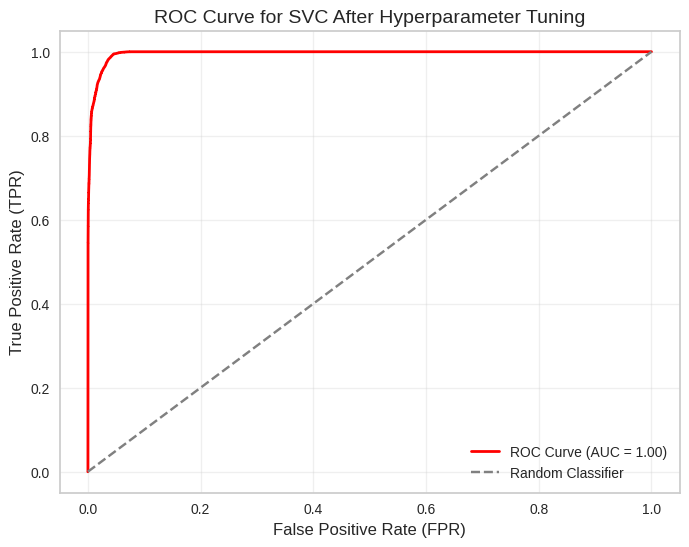

In [10]:
# Hitung probabilitas prediksi untuk kelas positif
y_prob_best_svc = best_svc.predict_proba(X_test)[:, 1]

# Hitung nilai False Positive Rate (FPR), True Positive Rate (TPR), dan thresholds
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_prob_best_svc)

# Hitung nilai AUC untuk SVC
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot ROC Curve untuk SVC
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='Red', lw=2, label=f'ROC Curve (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for SVC After Hyperparameter Tuning', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

Confusion Matrix:
[[51025  2336]
 [  427 53019]]


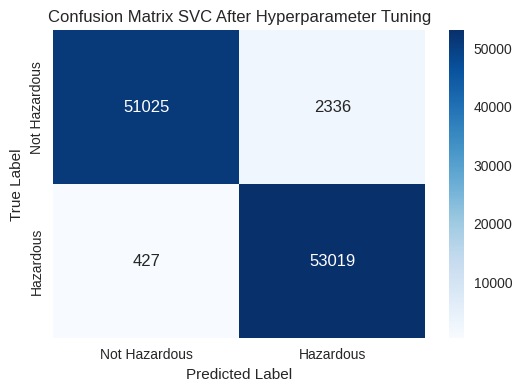

In [11]:
# Confusion Matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_best_svc)
print("Confusion Matrix:")
print(conf_matrix_svc)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVC After Hyperparameter Tuning')
plt.show()

In [12]:
# Menyimpan model svc terbaik
joblib.dump(best_svc, '/content/drive/My Drive/best_svc_model.pkl')


['/content/drive/My Drive/best_svc_model.pkl']